### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from tqdm.notebook import tqdm
from neuropy.core import Epoch
from neuropy.utils.mathutil import min_max_scaler
from neuropy import plotting
from scipy import stats
import pandas as pd
import subjects

### Signficant sequences(wcorr) compare SD vs NSD 

In [ ]:
sessions = subjects.pf_sess()

In [ ]:
replay_df = []
for sub, sess in enumerate(sessions):

    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    zt_starts = np.array([0,2.5,5])
    zt_stops = np.array([2.5,5,7.5])
    epochs = np.vstack((zt_starts,zt_stops)).T* 3600 + post[0]
    epochs = np.insert(epochs,0,maze,axis=0)
    labels = ['MAZE','0-2.5','2.5-5','5-7.5']

    for i, (t1,t2) in enumerate(epochs):
        replay_pbe = sess.replay_pbe.time_slice(t1,t2).to_dataframe()
        for direction in ["up", "down"]:
            perc = replay_pbe[direction + "_percentile_score"].values
            is_replay = (perc <= 5) | (perc >= 95)
            scores = replay_pbe[direction + "_score"].values[is_replay]
            order = replay_pbe[direction + "_replay_order"].values[is_replay]
            order, counts = np.unique(order, return_counts=True)
            df = pd.DataFrame(
                dict(
                    zt=labels[i],
                    replay_order=["r"],
                    prop=counts.sum() / len(replay_pbe),
                    # scores=np.abs(scores),
                    animal=sub,
                    grp=sess.tag,
                )
            )
            replay_df.append(df)

replay_df = pd.concat(replay_df, ignore_index=True)

# subjects.GroupData().save(replay_df,'replay_sig_frames')

In [ ]:

_,ax = plt.subplots() 
sns.barplot(data=replay_df, x="zt", y="prop",hue='grp')


### Distribution of wcorr-sequences SD vs NSD

In [ ]:
sessions = subjects.pf_sess()

In [ ]:
replay_df = []
for sub, sess in enumerate(sessions):

    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    zt_starts = np.array([0, 2.5, 5])
    zt_stops = np.array([2.5, 5, 7.5])
    epochs = np.vstack((zt_starts, zt_stops)).T * 3600 + post[0]
    epochs = np.insert(epochs, 0, maze, axis=0)
    labels = ["MAZE", "0-2.5", "2.5-5", "5-7.5"]

    replay_pbe = sess.replay_pbe.to_dataframe()

    for i, (t1, t2) in enumerate(epochs):
        indx = (replay_pbe.start > t1) & (replay_pbe.start < t2)
        epoch_pbe = replay_pbe[indx]
        # replay_pbe = sess.replay_pbe.time_slice(t1,t2).to_dataframe()
        for direction in ["up", "down"]:
            # perc = replay_pbe[direction + "_percentile_score"].values

            r2 = epoch_pbe[direction + "_score"].values ** 2
            zsc = epoch_pbe[direction + "_sequence_score"].values
            shuffle_scores = (
                sess.replay_pbe.metadata[direction + "_shuffle_score"][:, indx] ** 2
            )

            perc = np.array(
                [
                    stats.percentileofscore(shuffle_scores[:, i], r2[i], kind="strict")
                    for i in range(len(r2))
                ]
            )

            df = pd.DataFrame(
                dict(
                    zt=labels[i],
                    perc=perc,
                    zsc=zsc,
                    animal=sub,
                    grp=sess.tag,
                )
            )
            replay_df.append(df)

replay_df = pd.concat(replay_df, ignore_index=True)

subjects.GroupData().save(replay_df,'replay_wcorr')


In [ ]:


# _,ax = plt.subplots(1,1) 
# sns.barplot(data=replay_df,x='zt',y='perc',hue='grp',ax=ax, ci =99)

_,axs = plt.subplots(1,4) 
for i,t in enumerate(labels):

    df =replay_df[replay_df.zt==t] 
    d1 = df[df.grp=='NSD'].zsc.values
    d2 = df[df.grp=='SD'].zsc.values
    sns.ecdfplot(data=df, x="perc",hue='grp',ax=axs[i],lw=1)
    print(stats.kstest(d1,d2)) 


### wcorr vs jump distance

In [ ]:
sessions = subjects.pf_sess()

In [ ]:
get_jump_dist = lambda arr: np.diff(np.argmax(arr, axis=0)).mean()
wcorr_jump_df = []
for sub, sess in enumerate(sessions):

    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    zt_starts = np.array([0, 2.5, 5])
    zt_stops = np.array([2.5, 5, 7.5])
    epochs = np.vstack((zt_starts, zt_stops)).T * 3600 + post[0]
    epochs = np.insert(epochs, 0, maze, axis=0)
    labels = ["MAZE", "0-2.5", "2.5-5", "5-7.5"]

    replay_pbe = sess.replay_pbe.to_dataframe()

    for direction in ["up", "down"]:
        wcorr = np.abs(replay_pbe[direction + "_score"].values)
        posteriors = sess.replay_pbe.metadata[direction + "_posterior"]
        dx = 1 / posteriors[0].shape[0]
        jump_dist = np.array([get_jump_dist(_) for _ in posteriors]) * dx
        for i, (t1, t2) in enumerate(epochs):
            indx = (replay_pbe.start > t1) & (replay_pbe.start < t2)

            df = pd.DataFrame(
                dict(
                    zt=labels[i],
                    wcorr=wcorr[indx],
                    jump=np.abs(jump_dist[indx]),
                    animal=sub,
                    grp=sess.tag,
                )
            )
            wcorr_jump_df.append(df)

wcorr_jump_df = pd.concat(wcorr_jump_df, ignore_index=True)

# subjects.GroupData().save(replay_df,'replay_wcorr')


In [ ]:
_,ax = plt.subplots(1,1)
sns.violinplot(data=wcorr_jump_df,x='zt',y='jump',hue='grp',ax=ax)
# sns.displot(data=wcorr_jump_df,x='jump',y='wcorr',binwidth=(0.05,0.05),col='grp')

# _, axs = plt.subplots(1, 4)
# for i, t in enumerate(labels):

#     df = wcorr_jump_df[wcorr_jump_df.zt == t]
#     d1 = df[df.grp=='NSD'].jump.values
#     d2 = df[df.grp=='SD'].jump.values
#     sns.barplot(
#         data=df,
#         x='zt',
#         y="jump",
#         hue="grp",
#         ax=axs[i],
#         # lw=1,
#         # common_norm=False,
#         # common_bins=True,
#         # stat="probability",
#         # fill=False,
#         # element='poly',
#         # cumulative=True,
#     )
#     print(stats.kstest(d1,d2))


### Signficant sequences histogram radon transform

In [ ]:
sessions = subjects.nsd.pf_sess

In [ ]:
replay_df = []
for sub, sess in enumerate(sessions):

    post = sess.paradigm["post"].flatten()
    replay_pbe = sess.replay_pbe.to_dataframe()
    is_replay = replay_pbe.is_replay
    velocity_bool = np.abs(replay_pbe.velocity.values) > 100

    sig_events = np.logical_and(is_replay, velocity_bool)
    starts = replay_pbe.start.values[sig_events]
    bins = np.arange(post[0], post[0] + 2 * 3600, 600)
    hist_replay = np.histogram(starts, bins)[0]
    replay_df.append(
        pd.DataFrame(
            {
                "bins": ((bins[:-1] - post[0]) / 3600).round(2),
                "hist": hist_replay,
                "grp": sess.tag,
            }
        )
    )

replay_df = pd.concat(replay_df, ignore_index=True)


In [ ]:

fig = plotting.Fig(grid=(2, 2))
ax = fig.subplot(fig.gs[0])
sns.barplot(data=replay_df, x="bins", y="hist", hue="grp")


### Decoding visualization

In [ ]:
from hfuncs import plot_in_bokeh
import bokeh.plotting as bplot

sess = subjects.nsd.ratSday2[0]
post = sess.paradigm["post"].flatten()
replay_pbe = sess.replay_pbe.to_dataframe()
starts = sess.replay_pbe.starts
wcorr, scores, posteriors = [], [], []
for i, d in enumerate(["up", "down"]):
    scores.append(replay_pbe[d + "_percentile_score"].values)
    posteriors.extend(sess.replay_pbe.metadata[d + "_posterior"])
    wcorr.append(replay_pbe[d + "_score"].values)

wcorr = np.concatenate(wcorr)
scores = np.concatenate(scores)
starts = np.tile(starts, (2,)) - post[0]
scores_color = np.where((scores >= 95) | (scores <= 5), scores, 50)

n_epochs = 7000
annotate_dict = dict(evt=np.arange(n_epochs), wcorr=wcorr[:n_epochs])
bplot.output_notebook()
# bplot.output_file(subjects.figpath_sd/'test_wake_decoding.html')
p = plot_in_bokeh(
    starts[:n_epochs]/3600,
    scores[:n_epochs],
    [posteriors[_] for _ in range(n_epochs)],
    annotate=annotate_dict,
    color_by=scores_color[:n_epochs],
    palette="jet",
    size=8,
)
# # p.line(pos.time,pos.x/350 + 0.2,line_width=2,color='black')
bplot.show(p)


### Examples for figure4 sd paper

In [ ]:
sessions = subjects.nsd.ratSday2 + subjects.sd.ratSday3

# events= [[1221,2836,5072,2381,5179],[1326,1372,1824,1292,1516]]
events= [[316,164,1416,3310,4201,3642,6728,6868],[263,148,2078,1900,3859,3468,6861,5978]]


In [ ]:
replay_example_dict = {}
for sub, sess in enumerate(sessions):
    replay = sess.replay_pbe
    replay_df = sess.replay_pbe.to_dataframe()
    starts = sess.replay_pbe.starts
    wcorr, scores, posteriors = [], [], []
    for i, d in enumerate(["up", "down"]):
        scores.append(replay_df[d + "_percentile_score"].values)
        posteriors.extend(replay.metadata[d + "_posterior"])
        wcorr.append(replay_df[d + "_score"].values)
    wcorr = np.concatenate(wcorr)
    replay_example_dict[sess.tag] = dict(
        posteriors=[posteriors[p] for p in events[sub]], wcorr=wcorr[events[sub]]
    )

subjects.GroupData().save(replay_example_dict,'replay_examples')

### Mean replay score across all events as a function of time 

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import subjects
from neuropy import plotting
from neuropy.utils import signal_process
from neuropy.analyses import Pf1D
from neuropy.analyses import Decode1d

sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4

In [ ]:
from scipy import stats

replay_df = []
for sub, sess in enumerate(sessions):

    post = sess.paradigm["post"].flatten()
    replay_pbe = sess.replay_pbe.to_dataframe()
    starts = sess.replay_pbe.starts
    replay_score = replay_pbe.score
    bins = np.arange(post[0], post[0] + 2 * 3600, 600)

    mean_score = stats.binned_statistic(starts, replay_score, bins=bins)[0]
    replay_df.append(
        pd.DataFrame(
            {
                "bins": ((bins[:-1] - post[0]) / 3600).round(2),
                "hist": mean_score,
                "grp": sess.tag,
            }
        )
    )

replay_df = pd.concat(replay_df, ignore_index=True)


In [ ]:
from neuropy import plotting
import seaborn as sns

fig = plotting.Fig(grid=(2, 2))
ax = fig.subplot(fig.gs[0])
sns.lineplot(data=replay_df, x="bins", y="hist", hue="grp")


### Distribution of replay scores and comparison with shuffled scores

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import subjects
from neuropy import plotting
from neuropy.utils import signal_process
from neuropy.analyses import Pf1D
from neuropy.analyses import Decode1d

sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4

In [ ]:
from scipy import stats

score_df = []
for sub, sess in enumerate(sessions):

    post = sess.paradigm["post"].flatten()
    replay_pbe = sess.replay_pbe.to_dataframe()

    starts = sess.replay_pbe.starts
    replay_score = replay_pbe.score

    shuffle_scores = sess.replay_pbe.metadata["shuffle_score"].flatten()
    shuffle_starts = np.repeat(starts, 200)

    bins = np.arange(2) * 3600 + post[0]
    replay_df = pd.DataFrame(
        {
            "Zt": np.digitize(starts, bins),
            "starts": starts,
            "score": replay_score,
            "grp": sess.tag,
        }
    )
    shuffle_df = pd.DataFrame(
        {
            "Zt": np.digitize(shuffle_starts, bins),
            "starts": shuffle_starts,
            "score": shuffle_scores,
            "grp": f"{sess.tag}_shuffle",
        }
    )
    score_df.append(pd.concat([replay_df, shuffle_df]))

score_df = pd.concat(score_df, ignore_index=True)


In [ ]:
sess.replay_pbe.metadata["shuffle_score"].shape


In [ ]:
from neuropy import plotting
import seaborn as sns

fig = plotting.Fig(grid=(2, 2))
ax = fig.subplot(fig.gs[0])
sns.violinplot(data=score_df, x="Zt", y="score", hue="grp")


### Posterior time lag comparison SD vs NSD

In [ ]:
sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4

In [ ]:
import scipy.signal as sg
from scipy.ndimage import gaussian_filter1d

lag_time_all = []
for sub,sess in enumerate(sessions):
    post = sess.paradigm['post'].flatten()
    starts = sess.replay_pbe.starts
    # ind = (starts>=post[0]+2.5*3600) &(starts<=post[0]+5*3600)
    ind = starts<post[0]

    posteriors = sess.replay_pbe.metadata['up_posterior']
    posteriors = [posteriors[_] for _ in np.argwhere(ind).squeeze()] 
    posteriors = np.hstack(posteriors)

    npos,nt = posteriors.shape
    rows,cols = np.tril_indices(npos,-1)
    lags = sg.correlation_lags(nt,nt,mode='same')*0.02
    idx = (lags>=-0.5) & (lags<=0.5)
    lags = lags[idx]

    lag_time=np.zeros((npos,npos))
    for p1 in range(npos):
        for p2 in range(npos):
            xcorr = sg.correlate(posteriors[p1],posteriors[p2],mode='same')[idx]
            lag_time[p1,p2] = lags[gaussian_filter1d(xcorr,sigma=0.06/0.02).argmax()]

    lag_time_all.append(lag_time)

In [ ]:
_,axs = plt.subplots(2,2)

for i,lag_mat in enumerate(lag_time_all):

    ax = axs[0,i]
    im = ax.pcolormesh(lag_mat,cmap='bwr',vmin=-0.4,vmax=0.4)
    cb = plt.colorbar(im,ax=ax)

    ax2 = axs[1,i]
    im = ax2.pcolormesh(np.abs(lag_mat),cmap='jet',vmin=0,vmax=0.4)
    cb = plt.colorbar(im,ax=ax2)


### Which positions are being replayed the most in POST

In [ ]:
sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4

In [104]:
import scipy.signal as sg
from scipy.ndimage import gaussian_filter1d

mean_posterior = []
for sub,sess in enumerate(sessions):
    post = sess.paradigm['post'].flatten()
    starts = sess.replay_pbe.starts
    ind = (starts>=post[0]+2.5*3600) &(starts<=post[0]+5*3600)

    posteriors = sess.replay_pbe.metadata['up_posterior']
    posteriors = [posteriors[_] for _ in np.argwhere(ind).squeeze()] 
    mean_posterior.append(np.hstack(posteriors).mean(axis=1))



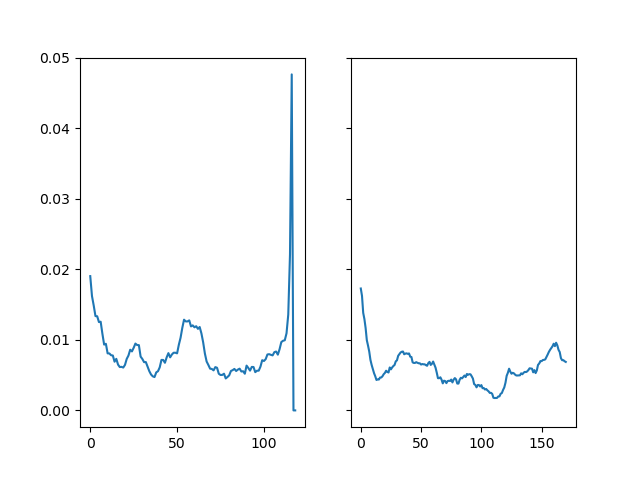

In [106]:
_,axs = plt.subplots(1,2,sharey=True)

for i,p in enumerate(mean_posterior):
    axs[i].plot(p)
